# Baseline model

Bertrand Thia (bt2513)

In this notebook, we are going to create a baseline model.

---

In [14]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight

np.random.seed(0)

# Loading the data and data preprocessing

In [15]:
train_labels = pd.read_csv('./train.csv')

### Splitting into training set and validation set 

In [16]:
train_set, valid_set = train_test_split(train_labels, test_size= 0.2, random_state= 0, 
                                        stratify= train_labels['label'])

In [17]:
print('Train size: %d \t Validation size: %d' %(len(train_set), len(valid_set)))

Train size: 901 	 Validation size: 226


In [18]:
train_set['label'].value_counts()

normal       280
bacterial    280
viral        280
covid         61
Name: label, dtype: int64

### Standardization

Let's load and standardized our data:

In [19]:
train_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True)

val_datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True)

Based on the litterature, the resizing of the input images for neural networks is generally around ~250 x 250 pixels. We are thus going to use the resizing 251 x 312, corresponding to the median shape of our images divided by 3. 

In [20]:
BATCH_SIZE = 32
W = 312
H = 251

X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= './train/',
                                            x_col = 'filename',
                                            y_col = 'label', 
                                            target_size = (W, H),
                                            batch_size= BATCH_SIZE, 
                                            color_mode= 'grayscale',
                                            seed= 0)

X_val = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= './train/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (W, H),
                                        batch_size= BATCH_SIZE, 
                                        color_mode= 'grayscale',
                                        seed= 0)

Found 901 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


# Model building

Let's create a simple baseline model here. Since our dataset is small, we are going to use dropout layers to avoid overfitting:

In [21]:
bas_model = Sequential()
bas_model.add(Conv2D(16, (3, 3), input_shape= (W, H, 1), activation= 'relu'))
bas_model.add(MaxPooling2D(pool_size= (2, 2)))

bas_model.add(Conv2D(32, (3, 3), activation= 'relu'))
bas_model.add(Conv2D(32, (3, 3), activation= 'relu'))
bas_model.add(BatchNormalization())
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Dropout(0.25)) 

bas_model.add(Flatten())

bas_model.add(Dense(units= 128, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 

bas_model.add(Dense(units= 64, activation= 'relu')) 
bas_model.add(Dropout(0.3)) 

bas_model.add(Dense(units= 4, activation= 'softmax'))

In [22]:
bas_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 310, 249, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 155, 124, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 153, 122, 32)      4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 151, 120, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 151, 120, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 60, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 60, 32)       

In [23]:
bas_model.compile(loss= 'categorical_crossentropy',
                 optimizer= Adam(lr= 0.001), 
                 metrics = ['accuracy'])

### Training 

In [24]:
epochs= 50
#es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, restore_best_weights= True, patience= 3)
checkpoint = ModelCheckpoint("baseline_model.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True)

Since our dataset is imbalanced, we are going to use class weigthing to address the issue:

In [25]:
train_set2 = train_set.copy()
train_set2['label'] = train_set2['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3})
class_weight = compute_class_weight('balanced', [0, 1, 2, 3], train_set2['label'])
class_weight

array([0.80446429, 3.69262295, 0.80446429, 0.80446429])

In [26]:
hist = bas_model.fit_generator(X_train, 
                                steps_per_epoch= len(train_set) // BATCH_SIZE, 
                                epochs= epochs, 
                                verbose= 1, 
                                validation_data = X_val, 
                                validation_steps= len(valid_set) // BATCH_SIZE,
                                class_weight= class_weight,
                                callbacks= [checkpoint])

Epoch 1/50
28/28 [==============================] - 35s 1s/step - loss: 4.5998 - accuracy: 0.4315 - val_loss: 1.2979 - val_accuracy: 0.4598

Epoch 00001: val_accuracy improved from -inf to 0.45982, saving model to baseline_model.hdf5
Epoch 2/50
28/28 [==============================] - 35s 1s/step - loss: 1.3750 - accuracy: 0.4902 - val_loss: 1.2942 - val_accuracy: 0.5155

Epoch 00002: val_accuracy improved from 0.45982 to 0.51546, saving model to baseline_model.hdf5
Epoch 3/50
28/28 [==============================] - 39s 1s/step - loss: 1.2382 - accuracy: 0.5178 - val_loss: 1.2487 - val_accuracy: 0.4794

Epoch 00003: val_accuracy did not improve from 0.51546
Epoch 4/50
28/28 [==============================] - 37s 1s/step - loss: 1.2398 - accuracy: 0.4776 - val_loss: 1.2421 - val_accuracy: 0.4021

Epoch 00004: val_accuracy did not improve from 0.51546
Epoch 5/50
28/28 [==============================] - 38s 1s/step - loss: 1.1519 - accuracy: 0.5259 - val_loss: 1.4862 - val_accuracy: 0.06

28/28 [==============================] - 37s 1s/step - loss: 0.1725 - accuracy: 0.9299 - val_loss: 0.7443 - val_accuracy: 0.6696

Epoch 00041: val_accuracy did not improve from 0.76289
Epoch 42/50
28/28 [==============================] - 37s 1s/step - loss: 0.2275 - accuracy: 0.9310 - val_loss: 1.2670 - val_accuracy: 0.6907

Epoch 00042: val_accuracy did not improve from 0.76289
Epoch 43/50
28/28 [==============================] - 35s 1s/step - loss: 0.1982 - accuracy: 0.9194 - val_loss: 0.8357 - val_accuracy: 0.7371

Epoch 00043: val_accuracy did not improve from 0.76289
Epoch 44/50
28/28 [==============================] - 36s 1s/step - loss: 0.1941 - accuracy: 0.9321 - val_loss: 1.1154 - val_accuracy: 0.6907

Epoch 00044: val_accuracy did not improve from 0.76289
Epoch 45/50
28/28 [==============================] - 38s 1s/step - loss: 0.1589 - accuracy: 0.9286 - val_loss: 1.1346 - val_accuracy: 0.7216

Epoch 00045: val_accuracy did not improve from 0.76289
Epoch 46/50
28/28 [========

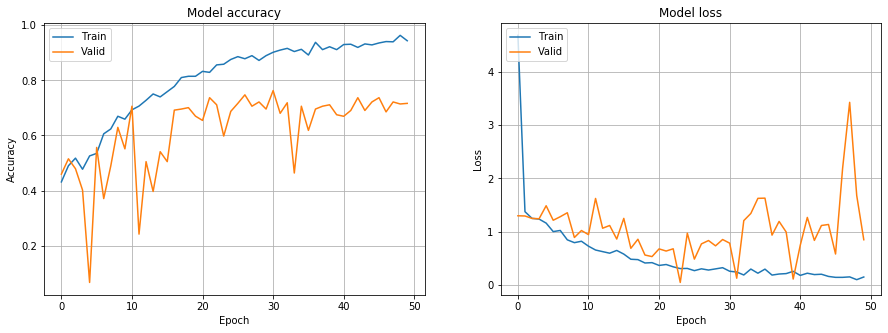

In [78]:
# Plotting the training curves

fig, axs = plt.subplots(1, 2, figsize= (15, 5))

# Plot training & validation accuracy values
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Valid'], loc='upper left')
axs[0].grid()

# Plot training & validation loss values
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(['Train', 'Valid'], loc='upper left')
plt.show()

We can see that the training accuracy gets very high while the validation accuracy  stops increasing after ~20 epochs and the validation loss increases: our model overfits. To address this issue, we will explore data augmentation later. 

### Evaluating our best model

In [42]:
# Loading the best weights
bas_model.load_weights("baseline_model.hdf5")

In [43]:
evaluation = bas_model.evaluate_generator(X_val)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

Accuracy on the validation set: 0.730


In [53]:
# Loading the validation set without shuffling the data to compare manually 
X_val2 = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= './train/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (W, H),
                                        batch_size= BATCH_SIZE, 
                                        color_mode= 'grayscale',
                                        shuffle= False)

Found 226 validated image filenames belonging to 4 classes.


In [54]:
pred = bas_model.predict_generator(X_val2)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([1, 3, 0, 0, 2, 2, 3, 0, 0, 0])

In [55]:
X_val.class_indices

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [56]:
y_val = valid_set['label'].map(X_val.class_indices).values

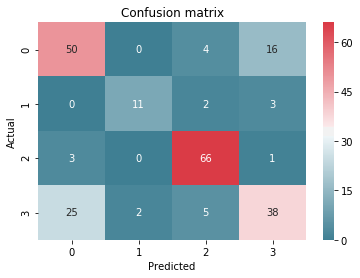

In [57]:
data = {'y_val': y_val, 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [59]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.71      0.68        70
           1       0.85      0.69      0.76        16
           2       0.86      0.94      0.90        70
           3       0.66      0.54      0.59        70

    accuracy                           0.73       226
   macro avg       0.75      0.72      0.73       226
weighted avg       0.73      0.73      0.73       226



**Our model seems to classify covid and normal cases quite well, but have some troubles with the bacterial and viral cases. Also, we saw that we have an overfitting issue. We will address this problem in our next work.**

# Predicting on the test set

In this section, we are going to predict the labels of the test set using our baseline model and save them.

### Loading the test set

In [60]:
test_df = pd.read_csv('test.csv')

In [62]:
test_datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True)
X_test = test_datagen.flow_from_directory('./test',
                                           classes = ['test'], 
                                           batch_size= BATCH_SIZE, 
                                           target_size = (W, H),
                                           color_mode= 'grayscale',
                                           shuffle= False)

Found 484 images belonging to 1 classes.


In [63]:
pred = bas_model.predict_generator(X_test)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([0, 2, 0, 3, 2, 2, 0, 0, 1, 2])

### Formatting the output like the submission example

In [64]:
submission = pd.read_csv('submission.csv')
submission.head()

,Id,label
0,0,bacterial
1,1,viral
2,2,normal
3,3,normal
4,4,bacterial


In [65]:
data = {'Id': test_df['id'], 'label': y_pred}
output = pd.DataFrame(data)
output['label'] = output['label'].map({0:'bacterial', 1: 'covid', 2: 'normal', 3: 'viral'})
output.head()

,Id,label
0,0,bacterial
1,1,normal
2,2,bacterial
3,3,viral
4,4,normal


In [66]:
# saving the output
output.to_csv('output_baseline.csv')

---

# Appendix

In [67]:
# Computing the accuracy manually to check 
(df['y_val'] == df['y_pred']).sum() / len(df)

0.7300884955752213